# Cortical network model

Analysis of 2 and 3-population cortical network models with a focus on the effect of the synaptic strength on the network dynamics evoked by a stimulus

## Imports

In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
# External imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Internal modules
from logger import logger
from network_model import *
from utils import *
from fileops import get_data_root, get_output_equivalent

# Initialize empty figures dictionary
figs = {}

# Set up logging folder
logdir = get_output_equivalent(get_data_root(), 'raw', 'model')

## Literature review

### Firing rate adaptation time constants

 2024/03/20 12:22:07: initialized NetworkModel(E, PV, SST)


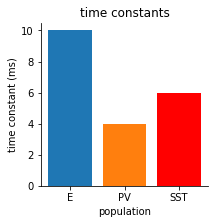

In [62]:
# Time constants (from Romero-Sosa et al. 2020)
tau = pd.Series(
    data={
        'E': 0.010, 
        'PV': .004, 
        'SST': .006
    },
    name='tau (s)'
)
populations = tau.index

figs['time constants'] = NetworkModel(tau=tau).plot_time_constants()

### Gain functions

 2024/03/20 12:22:08: initialized NetworkModel(E, PV, SST)


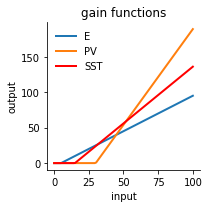

In [63]:
# Gain functions from Romero-Sosa et al. 2020
fgain = threshold_linear
fparams = pd.DataFrame(
    data={
        'x0': [5, 30, 15],  # E, PV, SST
        'A': [1, 2.7, 1.6], # E, PV, SST
    },
    index=pd.Index(populations, name='population'),
)

figs['fgain'] = NetworkModel(fgain=fgain, fparams=fparams).plot_fgain()

### Network connectivity matrices

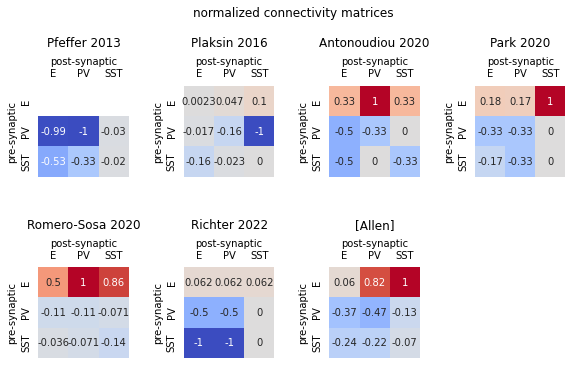

In [64]:
# Connectivity matrix (from Pfeffer et al. 2013)
W_pfeffer = pd.DataFrame(
    data=[
        [np.nan, np.nan, np.nan], # E -> E, PV, SST 
        [-1, -1.01, -0.03],  # PV -> E, PV, SST
        [-0.54, -0.33, -0.02]  # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Plaksin et al. 2016)
W_plaksin = pd.DataFrame(
    data=[
        [0.002, 0.04, 0.09],      # E -> E, PV, SST 
        [-0.015, -0.135, -0.86],  # PV -> E, PV, SST
        [-0.135, -0.02, 0]        # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Park et al. 2020)
W_park = pd.DataFrame(
    data=[
        [1.1, 1, 6],  # E -> E, PV, SST 
        [-2, -2, 0],  # PV -> E, PV, SST
        [-1, -2, 0]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Antonoudiou et al. 2020)
W_antonoudiou = pd.DataFrame(
    data=[
        [10, 30, 10],   # E -> E, PV, SST 
        [-15, -10, 0],  # PV -> E, PV, SST
        [-15, 0, -10]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Romero-Sosa et al. 2020, Figure 6A,B)
W_romero_sosa = pd.DataFrame(
    data=[
        [7, 14, 12],   # E -> E, PV, SST 
        [-1.5, -1.5, -1],  # PV -> E, PV, SST
        [-0.5, -1, -2]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Richter et al. 2022)
W_richter = pd.DataFrame(
    data=[
        [0.1, 0.1, 0.1],   # E -> E, PV, SST 
        [-0.8, -0.8, 0],  # PV -> E, PV, SST
        [-1.6, -1.6, 0]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Allen Brain Atlas)
W_allen = pd.DataFrame(
    data=[
        [ 0.06, 0.82, 1.],   # E -> E, PV, SST 
        [-0.37, -0.47, -0.13],  # PV -> E, PV, SST
        [-0.24, -0.22, -0.07],   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Comparative plot of connectivity matrices
Wdict = {
    'Pfeffer 2013': W_pfeffer,
    'Plaksin 2016': W_plaksin,
    'Antonoudiou 2020': W_antonoudiou,
    'Park 2020': W_park,
    'Romero-Sosa 2020': W_romero_sosa,
    'Richter 2022': W_richter,
    '[Allen]': W_allen, 
}
figs['connectivity comparisons'] = NetworkModel.plot_connectivity_matrix(Wdict, norm=True)

## 2-population (E, SST) model 

### Define model

 2024/03/20 12:22:13: initialized NetworkModel(E, SST)


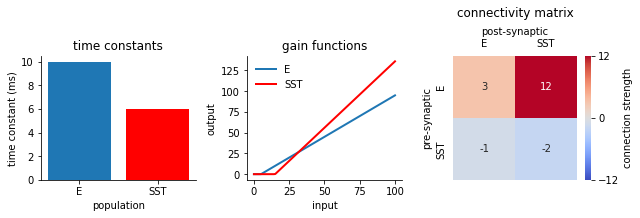

In [65]:
# Connectivity matrix
W2 = pd.DataFrame(
    data=[
        [3, 12],   # E -> E, SST
        [-1, -2]   # SST -> E, SST
    ], 
    index=pd.Index(['E', 'SST'], name='pre-synaptic'), 
    columns=pd.Index(['E', 'SST'], name='post-synaptic')
)

# Initialize model
model2 = NetworkModel(
    W=W2, 
    tau=tau.drop('PV'), 
    fgain=fgain, 
    fparams=fparams.drop('PV')
)

# Check balance of excitation vs inhibition
We = model2.get_net_excitation('SST')
Wi = model2.get_net_inhibition('SST')
if Wi < We:
    raise ValueError(f'net inhibition strength {Wi} < net excitation strength ({We})')

# Plot model2 summary
figs['2-pop model2'] = model2.plot_summary()

### Example simulation and stimulus amplitude sweep

 2024/03/20 12:22:15: external input:
E      6.0
SST    6.0
Name: external input, dtype: float64
 2024/03/20 12:22:15: NetworkModel(E, SST): running 0.5 s long simulation
 2024/03/20 12:22:15: simulation completed in 0.022 s
 2024/03/20 12:22:15: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 38.30it/s]


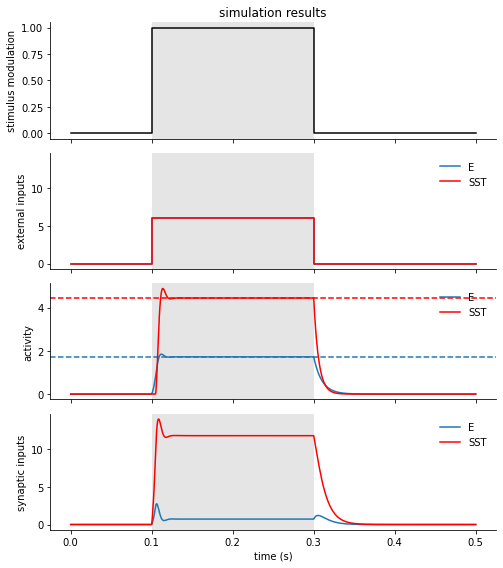

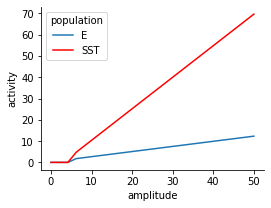

In [66]:
# External input
Ithr = fparams.loc['E', 'x0']  # E activation threshold
srel = pd.Series(1., index=model2.keys, name='external input')  # relative input strength
s = 1.2 * Ithr * srel
logger.info(f'external input:\n{s}')

# Simulate model, and extract steady-state stimulus-evoked activity
data = model2.simulate(s=s)
rss = model2.extract_steady_state(data)

# Plot results
figs['2-pop timeseries'] = model2.plot_timeseries(data, ss=rss, add_synaptic_drive=True)

# Define vector of amplitudes of external input w.r.t. reference value
rel_amps = np.linspace(0, 10, 25)
amps = rel_amps * Ithr

# Simulate model for each amplitude
sweep_data = model2.run_stim_sweep(srel, amps)

# Extract steady-state stimulus-evoked activity for each relative amplitude
sweep_rss = model2.extract_steady_state(sweep_data)
# Plot steady-state activity dependency on stimulus amplitude
figs['2-pop ss dep norm.'] = model2.plot_sweep_results(sweep_rss)

### Amplitude dependency profiles for various changes in network connectivity

In [67]:
# # Initialize empty dictionary of sweep results
# sweep_res_dict = {}

# # Vary global coupling strength
# Wscale = np.linspace(0, 10, 5)
# sweep_res_dict['Wscale'] = model2.run_W_sweep(Wscale, srel, amps, pre_key=None, post_key=None)

# # For each pair of populations, vary the coupling strength
# for prekey in model2.keys:
#     for postkey in model2.keys:
#         key = f'W{prekey}-{postkey}'
#         Wthr = model2.get_critical_value(prekey, postkey)
#         if prekey == postkey:
#             Wvec = Wthr * np.linspace(0, .9, 5)
#         else:
#             Wvec = Wthr * np.linspace(1.1, 5, 5)
#         Wvec = np.sort(Wvec)
#         sweep_res_dict[key] = model2.run_W_sweep(Wvec, srel, amps, pre_key=prekey, post_key=postkey)

# # Plot results of each sweep
# norm = False
# for key, sweep_res in sweep_res_dict.items():
#     figs[f'2-pop {key} sweep'] = model2.plot_sweep_results(sweep_res, norm=norm)

### Explore/optimize connectivity parameters

 2024/03/20 12:22:18: loading optimization results from /gpfs/scratch/lemait01/data/usnm/model/NetworkModel_E-SST_fgain_threshold_linear_fparams844eb9549d1762eb2940037d4bc00ed4_tau886def34a7aa4203060baf52d078a8cb_optimize_srel045a133be119e7f469f7fbe9276410a9_ref_profilesb1e115676a22aa5223007339a2e28d58_diffev_norm.csv
 2024/03/20 12:22:19: optimal connectivity matrix:
post-synaptic         E        SST
pre-synaptic                      
E              0.459178  19.997054
SST           -0.021347 -18.532425
 2024/03/20 12:22:19: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 34.23it/s]


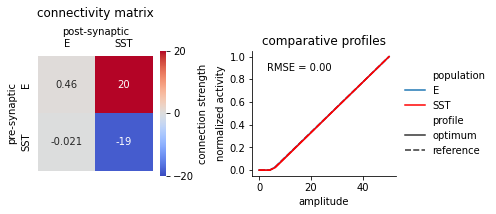

In [68]:
# Define reference population-specific activation profiles 
ref_profiles = pd.DataFrame(
    data={
        'E': threshold_linear(amps, **fparams.loc['E', :]),
        'SST': threshold_linear(amps, **fparams.loc['E', :])
    },
    index=pd.Index(amps, name='amplitude')
)
ref_profiles.columns.name = 'population'

# Determine whether to normalize activation profiles
norm = True

# Optimize connectivity matrix to minimize divergence with reference profiles
W2opt = ModelOptimizer.optimize(
    model2,
    srel, 
    ref_profiles, 
    norm=norm, 
    logdir=logdir,
    mpi=True,
    # kind='brute', 
    # npersweep=2,
)

# Perform stimulus sweep with optimal connectivity matrix
logger.info(f'optimal connectivity matrix:\n{W2opt}')
model2.W = W2opt
sweep_data = model2.run_stim_sweep(srel, amps)
sweep_rss = model2.extract_steady_state(sweep_data)

# Compare results to reference profiles
rmse = model2.evaluate_stim_sweep(ref_profiles, sweep_data, norm=norm)
sweep_comp = pd.concat({
    'optimum': sweep_rss,
    'reference': ref_profiles
}, axis=0, names=['profile'])

# Plot results
figs['2-pop opt'], axes = plt.subplots(1, 2, figsize=(7, 3))
model2.plot_connectivity_matrix(W=W2opt, ax=axes[0])
ax = axes[1]
model2.plot_sweep_results(sweep_comp, norm=norm, ax=ax, style='profile')
sns.move_legend(ax, bbox_to_anchor=(1, .5), loc='center left', frameon=False)
ax.set_title(f'comparative profiles')
ax.text(0.1, 0.9, f'RMSE = {rmse:.2f}', transform=ax.transAxes, ha='left', va='top')
figs['2-pop opt'].tight_layout()

## 3-population (E, SST, PV) model

### Define model

 2024/03/20 12:22:21: initialized NetworkModel(E, PV, SST)


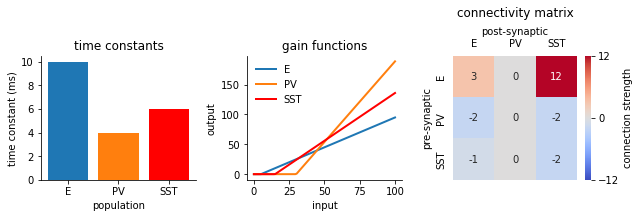

In [69]:
# Connectivity matrix
W3 = pd.DataFrame(
    data=[
        [3, 0, 12],   # E -> E, PV, SST
        [-2, 0, -2],  # PV -> E, PV, SST
        [-1, 0, -2]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Initialize model
model3 = NetworkModel(
    W=W3, 
    tau=tau, 
    fgain=fgain,
    fparams=fparams
)

# Plot model summary
figs['3-pop model'] = model3.plot_summary()

### Example simulation and stimulus amplitude sweep

 2024/03/20 12:22:23: external input:
E      6.0
PV     6.0
SST    6.0
Name: external input, dtype: float64
 2024/03/20 12:22:23: NetworkModel(E, PV, SST): running 0.5 s long simulation
 2024/03/20 12:22:23: simulation completed in 0.027 s
 2024/03/20 12:22:23: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 32.78it/s]


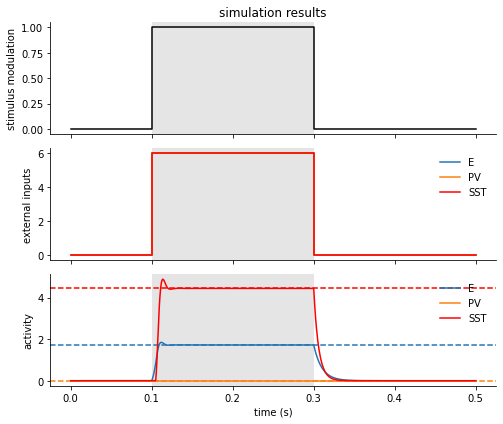

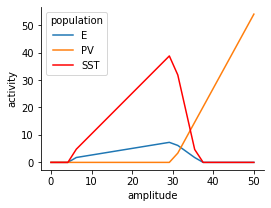

In [70]:
# External input
Ithr = fparams.loc['E', 'x0']  # E activation threshold
srel = pd.Series(1., index=model3.keys, name='external input')  # relative input strength
s = 1.2 * Ithr * srel
logger.info(f'external input:\n{s}')

# Simulate model, and extract steady-state stimulus-evoked activity
data = model3.simulate(s=s)
try:
    rss = model3.extract_steady_state(data)
except MetricError as e:
    logger.error(e)
    rss = None

# Plot results
figs['3-pop timeseries'] = model3.plot_timeseries(data, ss=rss)

# Define vector of amplitudes of external input w.r.t. reference value
rel_amps = np.linspace(0, 10, 25)
amps = rel_amps * Ithr

# Simulate model for each amplitude
sweep_data = model3.run_stim_sweep(srel, amps)
# Extract steady-state stimulus-evoked activity for each relative amplitude
sweep_rss = model3.extract_steady_state(sweep_data)
# Plot steady-state activity dependency on stimulus amplitude
figs['3-pop ss dep norm.'] = model3.plot_sweep_results(sweep_rss)

### Explore/optimize connectivity parameters

 2024/03/20 12:22:25: loading optimization results from /gpfs/scratch/lemait01/data/usnm/model/NetworkModel_E-PV-SST_fgain_threshold_linear_fparams811f5d27f5f880e6a7656fd9236b94d2_tau1484fecad09e40ae43ab6934a1eeef00_optimize_srel2c495f509ac266e1e377ea9b493c9f82_ref_profiles3d4f1611a60dedbeecfa106841d5f91d_diffev_norm.csv
 2024/03/20 12:22:26: optimal connectivity matrix:
post-synaptic         E         PV        SST
pre-synaptic                                 
E              0.642236   2.389170  17.988215
PV            -0.013057 -15.947265  -9.177568
SST           -0.228936  -2.671225 -19.864334
 2024/03/20 12:22:26: running stimulation sweep


100%|██████████| 25/25 [00:00<00:00, 28.08it/s]


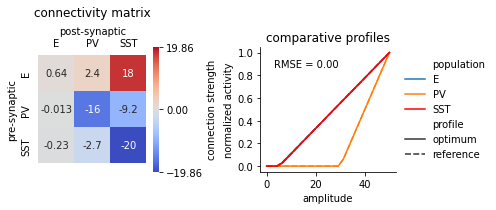

In [71]:
ref_profiles = pd.DataFrame(
    data={
        'E': threshold_linear(amps, **fparams.loc['E', :]),
        'PV': threshold_linear(amps, **fparams.loc['PV', :]),
        'SST': threshold_linear(amps, **fparams.loc['E', :])
    },
    index=pd.Index(amps, name='amplitude')
)
ref_profiles.columns.name = 'population'

# Determine whether to normalize activation profiles
norm = True

# Optimize connectivity matrix to minimize divergence with reference profiles
W3opt = ModelOptimizer.optimize(
    model3,
    srel, ref_profiles, 
    norm=norm, 
    logdir=logdir,
    mpi=True,
    # kind='brute', 
    # npersweep=5
)

# Perform stimulus sweep with optimal connectivity matrix
logger.info(f'optimal connectivity matrix:\n{W3opt}')
model3.W = W3opt
sweep_data = model3.run_stim_sweep(srel, amps)
sweep_rss = model3.extract_steady_state(sweep_data)

# Compare results to reference profiles
rmse = model3.evaluate_stim_sweep(ref_profiles, sweep_data, norm=norm)
sweep_comp = pd.concat({
    'optimum': sweep_rss,
    'reference': ref_profiles
}, axis=0, names=['profile'])

# Plot results
figs['3-pop opt'], axes = plt.subplots(1, 2, figsize=(7, 3))
model3.plot_connectivity_matrix(W=W3opt, ax=axes[0])
ax = axes[1]
model3.plot_sweep_results(sweep_comp, norm=norm, ax=ax, style='profile')
sns.move_legend(ax, bbox_to_anchor=(1, .5), loc='center left', frameon=False)
ax.set_title(f'comparative profiles')
ax.text(0.1, 0.9, f'RMSE = {rmse:.2f}', transform=ax.transAxes, ha='left', va='top')
figs['3-pop opt'].tight_layout()